🔄 Loading dataset year 2017 (Binary=True)...
✅ Loaded 2017. Shape: (2830743, 65)


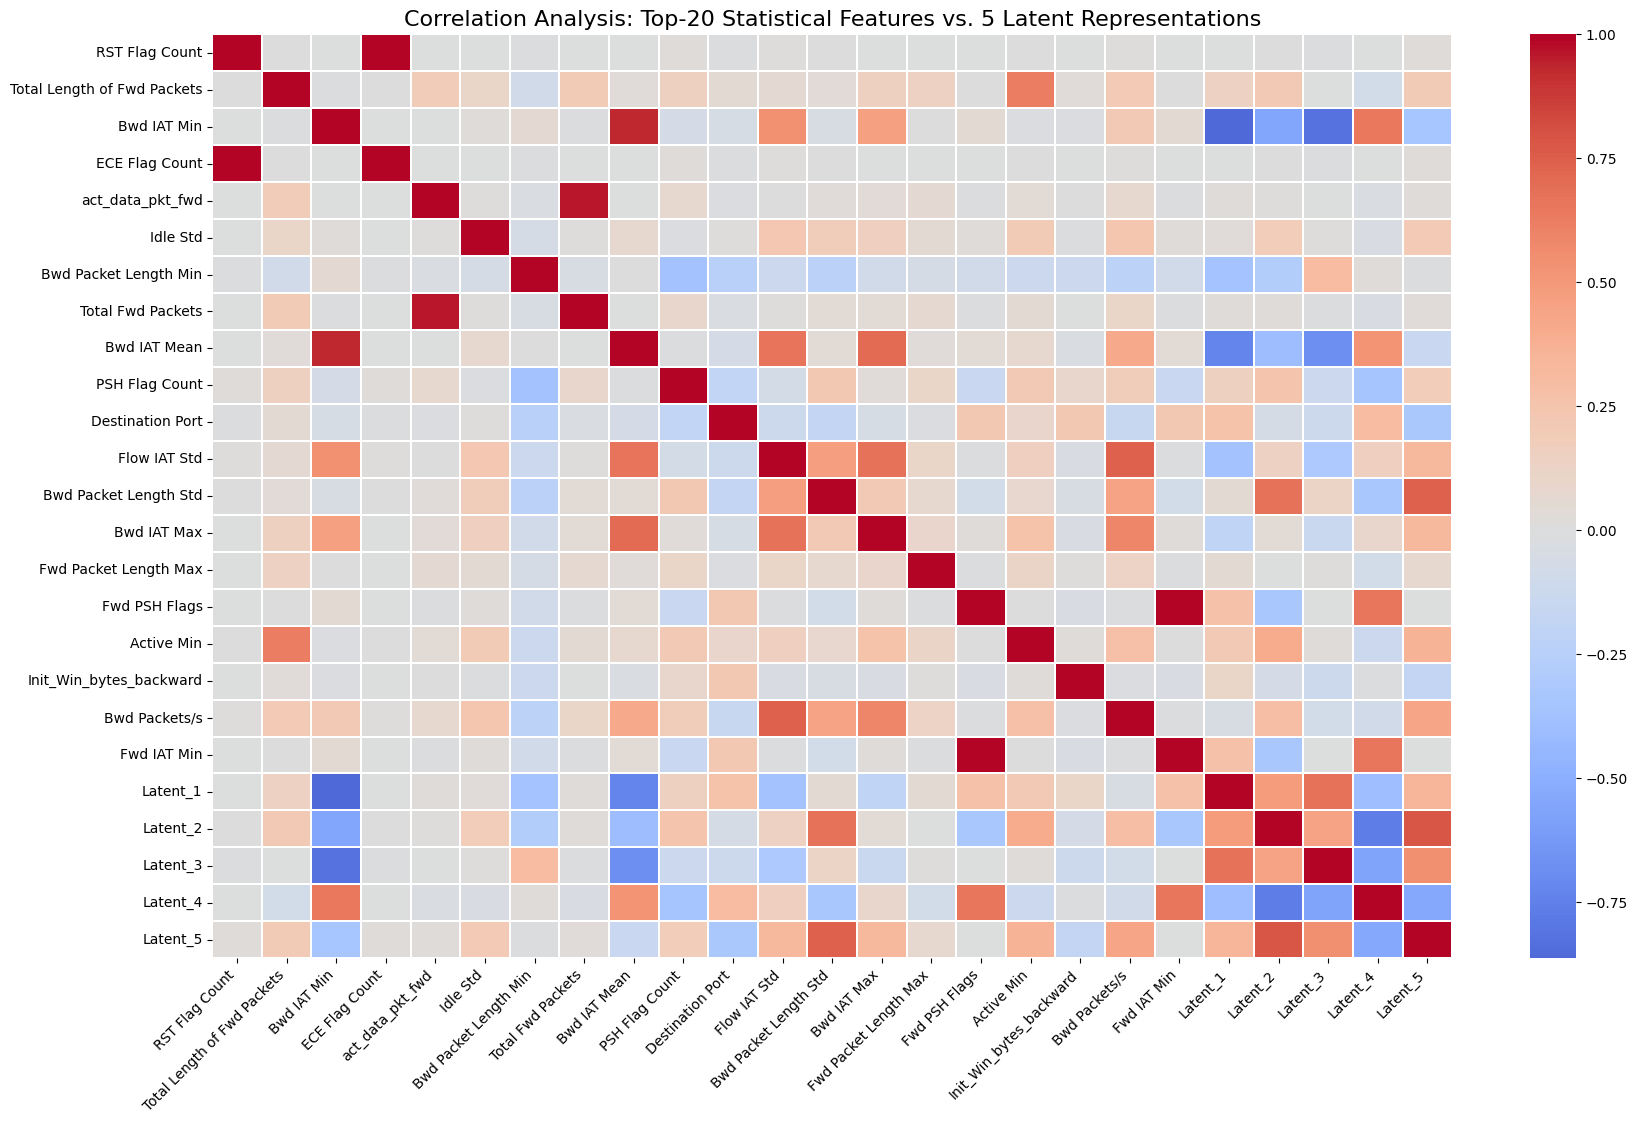

In [1]:
import sys
from pathlib import Path

# Setup path để import src
current_dir = Path.cwd()
root_dir = current_dir.parent
if str(root_dir) not in sys.path:
    sys.path.append(str(root_dir))

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import joblib
import torch

from src import config, preprocessing, autoencoder

# 1. Load dữ liệu mẫu và các artifact đã lưu [cite: 612-613]
df, y = preprocessing.load_single_dataset_year('2017', binary_mode=True)
df_sample = df.sample(n=50000, random_state=config.RANDOM_STATE)

# Load scaler và model AE [cite: 604-605]
scaler = joblib.load("../results/experiments/archived/exp_20251219_230042/models/scaler.joblib")
ae_model = autoencoder.DeepAutoencoder(input_dim=30, latent_dim=5)
ae_model.load_state_dict(torch.load("../results/experiments/archived/exp_20251219_230042/models/ae_model.pth"))
ae_model.eval()

# 2. Tiền xử lý và trích xuất 
X_scaled = scaler.transform(df_sample.values)

# Lấy 30 đặc trưng đầu cho AE đầu vào (Top-30 mRMR) [cite: 38, 530]
X_ae_input = X_scaled[:, :30]
with torch.no_grad():
    # Trích xuất 5 latent features (Z1 - Z5) [cite: 535]
    X_latent = ae_model.encoder(torch.FloatTensor(X_ae_input)).numpy()

# Lấy 20 đặc trưng đầu cho phần Fusion trực tiếp (Top-20 mRMR) [cite: 38, 543]
X_mrmr_20 = X_scaled[:, :20]

# 3. Tạo DataFrame Fusion với TÊN ĐẶC TRƯNG CỤ THỂ
# Thay vì đặt tên mRMR_1, ta lấy tên thật từ file config [cite: 519-522]
mrmr_20_names = config.mRMR_FEATURES[:20] 
latent_names = [f"Latent_{i+1}" for i in range(5)]

# Tạo DataFrame với tên cột đã ánh xạ
df_fusion = pd.DataFrame(
    np.hstack([X_mrmr_20, X_latent]), 
    columns=list(mrmr_20_names) + latent_names
)

# 4. Vẽ Heatmap
plt.figure(figsize=(20, 12))
corr = df_fusion.corr()

# Sử dụng mask để làm nổi bật vùng tương quan giữa mRMR và Latent nếu cần
sns.heatmap(corr, cmap='coolwarm', center=0, annot=False, linewidths=0.1)

# Chỉnh sửa hiển thị để tên không bị đè lên nhau
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.title('Correlation Analysis: Top-20 Statistical Features vs. 5 Latent Representations', fontsize=16)

# Lưu hình ảnh cho báo cáo 
plt.savefig("fusion_feature_named_correlation.png", dpi=300, bbox_inches='tight')
plt.show()